In [1]:
import numpy as np
import numpy.matlib
from numpy import exp, abs, sqrt
from scipy.stats import norm
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import tensorflow as tf
import matplotlib._color_data as mcd
import matplotlib.patches as mpatch
from itertools import product

tf.keras.backend.set_floatx('float64');

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

### DATA

In [2]:
# Size of the data
train_size = 40000; # Size of the training set
test_size = 4000; # Size of the test set
calibration_size = 4000;
param_in = 7; # Input size to the neural network

K_vector = np.array([31.6, 31.8, 32.0, 32.2, 32.4, 32.6, 32.8, 33.0, 33.2])
tau_vector = np.array([1/12, 2/12, 3/12, 4/12, 5/12, 6/12, 1]) 

N1 = len(K_vector)
N2 = len(tau_vector) 

l = 1/12 # 1 month of delivery, fixed
# NOTE: T_1 = tau, assumption for all the experiments

params_range = np.loadtxt('params_gridbased_with_NS.dat')
price = np.reshape(np.loadtxt('price_gridbased_with_NS.dat'), newshape = (train_size+test_size, N1, N2), order ='F')

In [3]:
# Train and test sets
params_range_train = params_range[np.arange(train_size), :] # size=[train_size, param_in]
params_range_test = params_range[train_size + np.arange(test_size), :] # size=[test_size, param_in]

price_train = price[np.arange(train_size), :, :] # size=[train_size, N1, N2]
price_test = price[train_size + np.arange(test_size), :, :] # size=[test_size, N1, N2]

# Calibration set
price_cal = price_test
params_cal = params_range_test

## FIRST STEP

In [4]:
# Define the neural network. There are many possibilites here.
print('Initializing model')

class MyModel(tf.keras.Model):
    def __init__(self):
        super(MyModel, self).__init__()
        self.dense1 = tf.keras.layers.Dense(30, activation = 'relu');
        self.dense2 = tf.keras.layers.Dense(N1*N2, activation = 'relu');
        self.reshape = tf.keras.layers.Reshape([N1,N2,1]);
        self.conv1 = tf.keras.layers.Conv2D(filters = 30, 
                                            kernel_size = 3, 
                                            padding = 'same', 
                                            activation = 'relu')
        self.conv2 = tf.keras.layers.Conv2D(filters = 1, 
                                            kernel_size = 3, 
                                            padding = 'same', 
                                            activation = None)

    def call(self, x):
        x = self.dense1(x)
        x = self.dense2(x)
        x = self.reshape(x)
        x = self.conv1(x);
        x = self.conv2(x);
        return x

# Create an instance of the model
model = MyModel()

# Choose optimizer and type of loss function
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.MeanSquaredError();

model.compile(loss = loss_object,
              optimizer = optimizer)
model.build(input_shape=(1,param_in))
model.summary()

model(tf.ones(shape = (1,param_in)));

model.load_weights('opt_weight_gridbased_conv_with_NS.h5')

Initializing model
Model: "my_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                multiple                  240       
_________________________________________________________________
dense_1 (Dense)              multiple                  1953      
_________________________________________________________________
reshape (Reshape)            multiple                  0         
_________________________________________________________________
conv2d (Conv2D)              multiple                  300       
_________________________________________________________________
conv2d_1 (Conv2D)            multiple                  271       
Total params: 2,764
Trainable params: 2,764
Non-trainable params: 0
_________________________________________________________________

If you intended to run this layer in float64, you can safely ignore this warning. If in doubt, this wa

### Training (if weights are not loaded)

Compiling train step
Compiling test step


Starting to train
Epoch 1/200, Loss: 0.0423652042,  Test Loss: 0.0251625353, Delta Test Loss: 0.0251625353
Epoch 2/200, Loss: 0.0210368233,  Test Loss: 0.0190695753, Delta Test Loss: 0.0060929600
Epoch 3/200, Loss: 0.0202255965,  Test Loss: 0.0195352224, Delta Test Loss: 0.0004656471
Epoch 4/200, Loss: 0.0197439600,  Test Loss: 0.0188075880, Delta Test Loss: 0.0007276344
Epoch 5/200, Loss: 0.0192065485,  Test Loss: 0.0178974770, Delta Test Loss: 0.0009101110
Epoch 6/200, Loss: 0.0190756949,  Test Loss: 0.0174137868, Delta Test Loss: 0.0004836902
Epoch 7/200, Loss: 0.0189212811,  Test Loss: 0.0174560565, Delta Test Loss: 0.0000422697
Epoch 8/200, Loss: 0.0190734181,  Test Loss: 0.0171242841, Delta Test Loss: 0.0003317724
Epoch 9/200, Loss: 0.0185010681,  Test Loss: 0.0173366338, Delta Test Loss: 0.0002123498
Epoch 10/200, Loss: 0.0185194844,  Test Loss: 0.0240970986, Delta Test Loss: 0.0067604648
Epoch 11/200, Loss: 0.0184643081,  Test Loss: 0.

Epoch 29/200, Loss: 0.0142587607,  Test Loss: 0.0122255101, Delta Test Loss: 0.0004970979
Epoch 30/200, Loss: 0.0135575618,  Test Loss: 0.0117647598, Delta Test Loss: 0.0004607503
Epoch 31/200, Loss: 0.0131922475,  Test Loss: 0.0111831978, Delta Test Loss: 0.0005815619
Epoch 32/200, Loss: 0.0130110836,  Test Loss: 0.0134427011, Delta Test Loss: 0.0022595033
Epoch 33/200, Loss: 0.0122326820,  Test Loss: 0.0133315624, Delta Test Loss: 0.0001111387
Epoch 34/200, Loss: 0.0117414777,  Test Loss: 0.0100604518, Delta Test Loss: 0.0032711106
Epoch 35/200, Loss: 0.0112572778,  Test Loss: 0.0093449513, Delta Test Loss: 0.0007155005
Epoch 36/200, Loss: 0.0107106098,  Test Loss: 0.0115054453, Delta Test Loss: 0.0021604940
Epoch 37/200, Loss: 0.0101499922,  Test Loss: 0.0111598518, Delta Test Loss: 0.0003455935
Epoch 38/200, Loss: 0.0096242558,  Test Loss: 0.0103727648, Delta Test Loss: 0.0007870870
Epoch 39/200, Loss: 0.0090407699,  Test Loss: 0.0073613167, Delta Test Loss: 0.0030114481
Epoch 40/2

Epoch 120/200, Loss: 0.0005289502,  Test Loss: 0.0002346726, Delta Test Loss: 0.0000305168
Epoch 121/200, Loss: 0.0005251772,  Test Loss: 0.0006782633, Delta Test Loss: 0.0004435908
Epoch 122/200, Loss: 0.0005330282,  Test Loss: 0.0017563527, Delta Test Loss: 0.0010780894
Epoch 123/200, Loss: 0.0005148215,  Test Loss: 0.0003764389, Delta Test Loss: 0.0013799138
Epoch 124/200, Loss: 0.0005201219,  Test Loss: 0.0013882570, Delta Test Loss: 0.0010118181
Epoch 125/200, Loss: 0.0005147176,  Test Loss: 0.0005498927, Delta Test Loss: 0.0008383643
Epoch 126/200, Loss: 0.0005378366,  Test Loss: 0.0001103532, Delta Test Loss: 0.0004395395
Epoch 127/200, Loss: 0.0005170331,  Test Loss: 0.0000745723, Delta Test Loss: 0.0000357809
Epoch 128/200, Loss: 0.0004863879,  Test Loss: 0.0001123527, Delta Test Loss: 0.0000377804
Epoch 129/200, Loss: 0.0005217173,  Test Loss: 0.0003342004, Delta Test Loss: 0.0002218477
Epoch 130/200, Loss: 0.0004840750,  Test Loss: 0.0000756377, Delta Test Loss: 0.0002585628

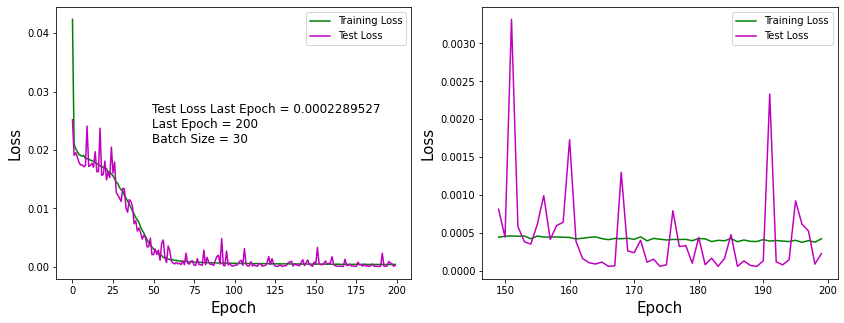

In [34]:
EPOCHS = 200         # Number of steps training
batch_size = 30;

patience = 20
delta = 0.0002

# Choose what type of information you want to print
train_loss = tf.keras.metrics.Mean(name='train_mean')
test_loss = tf.keras.metrics.Mean(name='test_mean')

# To speed up training we need to create a some object which can send the data 
# fast to the GPU. Notice that they depend on the bactch_size
train_ds = tf.data.Dataset.from_tensor_slices(
              (params_range_train, price_train)).shuffle(10000).batch(batch_size)

test_ds = tf.data.Dataset.from_tensor_slices((params_range_test, price_test)).batch(batch_size)  

# Define the early stop function
def early_stop(loss_vec):
    delta_loss = np.abs(np.diff(loss_vec))
    delta_loss = delta_loss[-patience:]
    return (np.prod(delta_loss < delta))

# Next we compile a few low level functions which will compute the actual gradient.
print('Compiling train step')
@tf.function
def train_step(input_param, prices):
    with tf.GradientTape() as tape:
        # training=True is only needed if there are layers with different
        # behavior during training versus inference (e.g. Dropout).
        predictions = model(input_param, training=True)
        loss = loss_object(prices, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_loss(loss)

print('Compiling test step')
@tf.function
def test_step(input_param, prices):
    # training=False is only needed if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    predictions = model(input_param, training=False)
    t_loss = loss_object(prices, predictions)

    test_loss(t_loss)

# Vectors of loss
test_loss_vec = np.array([0.0])
train_loss_vec = np.array([0.0])    
    
# We start to train the network.
print('\n\nStarting to train')
for epoch in range(EPOCHS):
    
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    test_loss.reset_states()

    
    for input_param, prices in train_ds:
        # For each batch of images, and prices, compute the gradient and update 
        # the gradient of the network
        train_step(input_param, prices)

    for test_images, test_prices in test_ds:
        # For each of the test data, compute how the network performs on the data
        # We do not compute any gradients here
        test_step(test_images, test_prices)

    # Print some usfull information
    template = 'Epoch {0}/{1}, Loss: {2:.10f},  Test Loss: {3:.10f}, Delta Test Loss: {4:.10f}'
    print(template.format(epoch+1,
                          EPOCHS,
                          train_loss.result().numpy(),
                          test_loss.result().numpy(),
                          np.abs(test_loss.result()-test_loss_vec[-1])
                          ))
    
    train_loss_vec = np.append(train_loss_vec, train_loss.result())
    test_loss_vec = np.append(test_loss_vec, test_loss.result())
    
    if (epoch > patience):
        if early_stop(test_loss_vec):
            print('Early stopping at epoch = ', epoch+1)
            break

model.save_weights('opt_weight_gridbased_conv_with_NS.h5')                   
          
l3 = plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(np.arange(epoch+1), train_loss_vec[1:], '-g')
plt.plot(np.arange(epoch+1), test_loss_vec[1:], '-m')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel("Epoch", fontsize=15, labelpad=5);
plt.ylabel("Loss", fontsize=15, labelpad=5);
text = 'Test Loss Last Epoch = %.10f' %test_loss.result().numpy() + '\n'+ 'Last Epoch = %d' %(epoch+1)  + '\n'+ 'Batch Size = %d' %batch_size 
plt.text(epoch//4, train_loss_vec[1]/2, text , fontsize=12);

plt.subplot(1,2,2)
plt.plot(np.arange(epoch-50, epoch+1), train_loss_vec[(epoch-50+1):], '-g')
plt.plot(np.arange(epoch-50, epoch+1), test_loss_vec[(epoch-50+1):], '-m')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel("Epoch", fontsize=15, labelpad=5);
plt.ylabel("Loss", fontsize=15, labelpad=5);

#l3.savefig('loss_step1_gridbased_conv_with_NS.pdf')

In [5]:
price_predicted_train = model(params_range_train).numpy()
price_predicted_train = np.squeeze(price_predicted_train)
price_predicted_test = model(params_range_test).numpy()
price_predicted_test = np.squeeze(price_predicted_test)

err_training_train = abs(price_predicted_train-price_train)/price_train
err_training_test = abs(price_predicted_test-price_test)/price_test

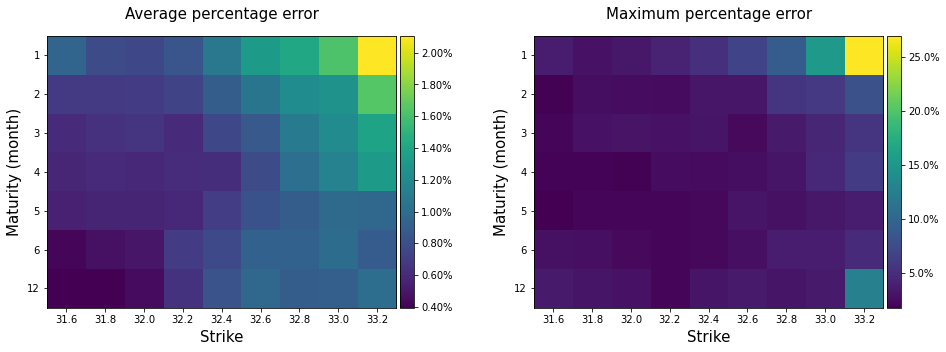

In [6]:
K_label = np.array([31.6, 31.8, 32.0, 32.2, 32.4, 32.6, 32.8, 33.0, 33.2])
tau_label = ['1','2', '3', '4', '5', '6', '12']

f = plt.figure(1,figsize=(16,5))
ax = plt.subplot(1,2,1)
mean_err = np.mean(100*err_training_train,axis = 0)
plt.title("Average percentage error", fontsize = 15, y = 1.04)
plt.imshow(np.transpose(mean_err))
plt.colorbar(format = mtick.PercentFormatter(), pad=0.01, fraction=0.046)
ax.set_xticks(np.linspace(0,N1-1,N1))
ax.set_xticklabels(K_label)
ax.set_yticks(np.linspace(0,N2-1,N2))
ax.set_yticklabels(tau_label)
plt.xlabel("Strike",fontsize=15,labelpad=5)
plt.ylabel("Maturity (month)",fontsize=15,labelpad=5)

ax = plt.subplot(1,2,2)
max_err = np.max(100*err_training_train,axis = 0)
plt.title("Maximum percentage error", fontsize = 15, y = 1.04)
plt.imshow(np.transpose(max_err))
plt.colorbar(format = mtick.PercentFormatter(), pad=0.01, fraction=0.046)
ax.set_xticks(np.linspace(0,N1-1,N1))
ax.set_xticklabels(K_label)
ax.set_yticks(np.linspace(0,N2-1,N2))
ax.set_yticklabels(tau_label)
plt.xlabel("Strike",fontsize=15,labelpad=5);
plt.ylabel("Maturity (month)",fontsize=15,labelpad=5);

#f.savefig('error_step1_train_gridbased_conv_with_NS.pdf', bbox_inches = 'tight', pad_inches = 0.01)

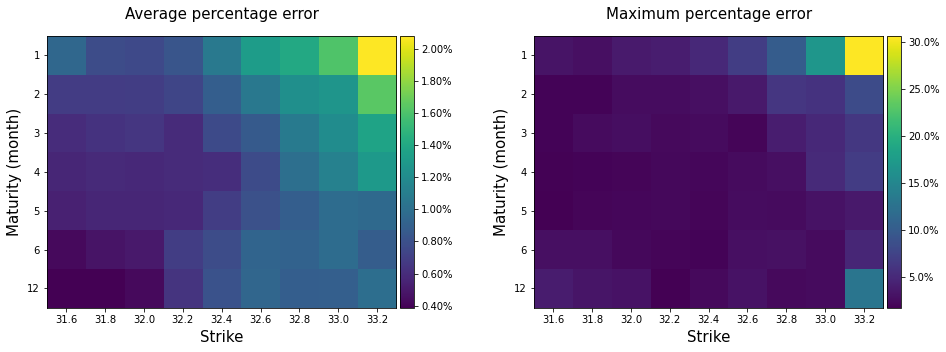

In [7]:
K_label = np.array([31.6, 31.8, 32.0, 32.2, 32.4, 32.6, 32.8, 33.0, 33.2])
tau_label = ['1','2', '3', '4', '5', '6', '12']

f = plt.figure(1,figsize=(16,5))
ax = plt.subplot(1,2,1)
mean_err = np.mean(100*err_training_test,axis = 0)
plt.title("Average percentage error", fontsize = 15, y = 1.04)
plt.imshow(np.transpose(mean_err))
plt.colorbar(format = mtick.PercentFormatter(), pad=0.01, fraction=0.046)
ax.set_xticks(np.linspace(0,N1-1,N1))
ax.set_xticklabels(K_label)
ax.set_yticks(np.linspace(0,N2-1,N2))
ax.set_yticklabels(tau_label)
plt.xlabel("Strike",fontsize=15,labelpad=5);
plt.ylabel("Maturity (month)",fontsize=15,labelpad=5);

ax = plt.subplot(1,2,2)
max_err = np.max(100*err_training_test,axis = 0)
plt.title("Maximum percentage error", fontsize = 15, y = 1.04)
plt.imshow(np.transpose(max_err))
plt.colorbar(format = mtick.PercentFormatter(), pad=0.01, fraction=0.046)
ax.set_xticks(np.linspace(0,N1-1,N1))
ax.set_xticklabels(K_vector)
ax.set_yticks(np.linspace(0,N2-1,N2))
ax.set_yticklabels(tau_label)
plt.xlabel("Strike",fontsize=15,labelpad=5);
plt.ylabel("Maturity (month)",fontsize=15,labelpad=5);

#f.savefig('error_step1_test_gridbased_conv_with_NS.pdf', bbox_inches = 'tight', pad_inches = 0.01)

## SECOND STEP

In [8]:
# The network is done training. We are ready to start on the Calibration step
print('\n\nCalibration step')

EPOCHS_CAL = 1000     # Number of steps calebrating

# Choose optimizer and type of loss function
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.MeanSquaredError();
calibration_loss = tf.keras.metrics.Mean(name='calibration_mean')

# This does depend on the calibration size
cal_ds = tf.data.Dataset.from_tensor_slices(
              (price_cal)).batch(calibration_size)

print('Compiling calibration step')
@tf.function
def calibration_step(input_guess, prices):
        
        with tf.GradientTape() as tape:
            tape.watch(input_guess)
            prediction = model(input_guess)
            c_loss = loss_object(prices, prediction)
        calibration_loss(c_loss)
        grads = tape.gradient(c_loss, [input_guess])
        optimizer.apply_gradients(zip(grads, [input_guess]))

# We need to guess some initial model parameters.
input_guess = params_cal + np.random.rand(calibration_size, param_in)*np.array([0.05, 0.05, 0.5, 0.5, 0.05, 0.05, 0.05])

# I just copy the starting parameters for convenience. This is not necessary
old_input_guess = input_guess.copy();

# Important: First convert to tensor, then to variable
tf_input_guess = tf.convert_to_tensor(input_guess)
tf_var_input_guess = tf.Variable(tf_input_guess);

# Start the actual calibration
for epoch in range(EPOCHS_CAL):
    calibration_loss.reset_states()
    for labels in cal_ds:
        # For each set of labels, compute the gradient of the network, and 
        # preform a gradient update on the input parameters. 
        calibration_step(tf_var_input_guess, labels)

    template = 'Epoch_cal {}, Loss: {}'
    print(template.format(epoch+1,
                          calibration_loss.result(),
                          ))

new_input_guess = tf_var_input_guess.numpy();

X = new_input_guess-old_input_guess
print(np.linalg.norm(X, 'fro'));



Calibration step
Compiling calibration step
Epoch_cal 1, Loss: 0.09803599864244461
Epoch_cal 2, Loss: 0.09721215069293976
Epoch_cal 3, Loss: 0.09638165682554245
Epoch_cal 4, Loss: 0.09555082768201828
Epoch_cal 5, Loss: 0.09472181648015976
Epoch_cal 6, Loss: 0.09389577805995941
Epoch_cal 7, Loss: 0.09307333827018738
Epoch_cal 8, Loss: 0.09225495159626007
Epoch_cal 9, Loss: 0.09144090116024017
Epoch_cal 10, Loss: 0.09063150733709335
Epoch_cal 11, Loss: 0.08982694149017334
Epoch_cal 12, Loss: 0.08902742713689804
Epoch_cal 13, Loss: 0.088233083486557
Epoch_cal 14, Loss: 0.08744404464960098
Epoch_cal 15, Loss: 0.08666044473648071
Epoch_cal 16, Loss: 0.08588238060474396
Epoch_cal 17, Loss: 0.0851099044084549
Epoch_cal 18, Loss: 0.0843430608510971
Epoch_cal 19, Loss: 0.08358190208673477
Epoch_cal 20, Loss: 0.08282653242349625
Epoch_cal 21, Loss: 0.08207692950963974
Epoch_cal 22, Loss: 0.08133313059806824
Epoch_cal 23, Loss: 0.08059515058994293
Epoch_cal 24, Loss: 0.079863041639328
Epoch_cal

Epoch_cal 134, Loss: 0.028659485280513763
Epoch_cal 135, Loss: 0.02839139848947525
Epoch_cal 136, Loss: 0.028125829994678497
Epoch_cal 137, Loss: 0.02786274626851082
Epoch_cal 138, Loss: 0.02760211192071438
Epoch_cal 139, Loss: 0.027343926951289177
Epoch_cal 140, Loss: 0.027088157832622528
Epoch_cal 141, Loss: 0.02683478593826294
Epoch_cal 142, Loss: 0.02658379264175892
Epoch_cal 143, Loss: 0.026335153728723526
Epoch_cal 144, Loss: 0.026088856160640717
Epoch_cal 145, Loss: 0.025844881311058998
Epoch_cal 146, Loss: 0.02560320682823658
Epoch_cal 147, Loss: 0.025363806635141373
Epoch_cal 148, Loss: 0.02512666955590248
Epoch_cal 149, Loss: 0.024891767650842667
Epoch_cal 150, Loss: 0.02465907856822014
Epoch_cal 151, Loss: 0.0244285948574543
Epoch_cal 152, Loss: 0.02420029789209366
Epoch_cal 153, Loss: 0.02397417277097702
Epoch_cal 154, Loss: 0.023750189691781998
Epoch_cal 155, Loss: 0.023528333753347397
Epoch_cal 156, Loss: 0.023308591917157173
Epoch_cal 157, Loss: 0.023090936243534088
Epoc

Epoch_cal 331, Loss: 0.005164305213838816
Epoch_cal 332, Loss: 0.005127793177962303
Epoch_cal 333, Loss: 0.005091667175292969
Epoch_cal 334, Loss: 0.005055922549217939
Epoch_cal 335, Loss: 0.005020547658205032
Epoch_cal 336, Loss: 0.004985548090189695
Epoch_cal 337, Loss: 0.004950923379510641
Epoch_cal 338, Loss: 0.004916672594845295
Epoch_cal 339, Loss: 0.00488278130069375
Epoch_cal 340, Loss: 0.004849247634410858
Epoch_cal 341, Loss: 0.004816072061657906
Epoch_cal 342, Loss: 0.004783251788467169
Epoch_cal 343, Loss: 0.0047507695853710175
Epoch_cal 344, Loss: 0.0047186268493533134
Epoch_cal 345, Loss: 0.004686831962317228
Epoch_cal 346, Loss: 0.004655370954424143
Epoch_cal 347, Loss: 0.004624245688319206
Epoch_cal 348, Loss: 0.004593447782099247
Epoch_cal 349, Loss: 0.004562985152006149
Epoch_cal 350, Loss: 0.004532832186669111
Epoch_cal 351, Loss: 0.004503006115555763
Epoch_cal 352, Loss: 0.004473498556762934
Epoch_cal 353, Loss: 0.004444299265742302
Epoch_cal 354, Loss: 0.0044154087

Epoch_cal 526, Loss: 0.0020801497157663107
Epoch_cal 527, Loss: 0.002074488205835223
Epoch_cal 528, Loss: 0.0020688653457909822
Epoch_cal 529, Loss: 0.0020632825326174498
Epoch_cal 530, Loss: 0.0020577390678226948
Epoch_cal 531, Loss: 0.002052233787253499
Epoch_cal 532, Loss: 0.002046765061095357
Epoch_cal 533, Loss: 0.002041335217654705
Epoch_cal 534, Loss: 0.002035941695794463
Epoch_cal 535, Loss: 0.002030585426837206
Epoch_cal 536, Loss: 0.0020252664107829332
Epoch_cal 537, Loss: 0.002019981388002634
Epoch_cal 538, Loss: 0.002014731988310814
Epoch_cal 539, Loss: 0.002009517978876829
Epoch_cal 540, Loss: 0.002004338428378105
Epoch_cal 541, Loss: 0.0019991910085082054
Epoch_cal 542, Loss: 0.0019940754864364862
Epoch_cal 543, Loss: 0.0019889932591468096
Epoch_cal 544, Loss: 0.0019839410670101643
Epoch_cal 545, Loss: 0.0019789226353168488
Epoch_cal 546, Loss: 0.0019739349372684956
Epoch_cal 547, Loss: 0.0019689789041876793
Epoch_cal 548, Loss: 0.0019640545360744
Epoch_cal 549, Loss: 0.0

Epoch_cal 721, Loss: 0.0013737305998802185
Epoch_cal 722, Loss: 0.001371136517263949
Epoch_cal 723, Loss: 0.0013685474405065179
Epoch_cal 724, Loss: 0.0013659633696079254
Epoch_cal 725, Loss: 0.0013633847702294588
Epoch_cal 726, Loss: 0.001360811060294509
Epoch_cal 727, Loss: 0.0013582424726337194
Epoch_cal 728, Loss: 0.001355678541585803
Epoch_cal 729, Loss: 0.0013531201984733343
Epoch_cal 730, Loss: 0.0013505663955584168
Epoch_cal 731, Loss: 0.0013480177149176598
Epoch_cal 732, Loss: 0.0013454738073050976
Epoch_cal 733, Loss: 0.0013429345563054085
Epoch_cal 734, Loss: 0.0013404004275798798
Epoch_cal 735, Loss: 0.001337871770374477
Epoch_cal 736, Loss: 0.001335347187705338
Epoch_cal 737, Loss: 0.0013328274944797158
Epoch_cal 738, Loss: 0.001330312225036323
Epoch_cal 739, Loss: 0.0013278023106977344
Epoch_cal 740, Loss: 0.0013252967037260532
Epoch_cal 741, Loss: 0.001322795869782567
Epoch_cal 742, Loss: 0.001320299576036632
Epoch_cal 743, Loss: 0.0013178078224882483
Epoch_cal 744, Loss

Epoch_cal 914, Loss: 0.0009474246762692928
Epoch_cal 915, Loss: 0.000945544452406466
Epoch_cal 916, Loss: 0.0009436673135496676
Epoch_cal 917, Loss: 0.0009417933179065585
Epoch_cal 918, Loss: 0.0009399225236847997
Epoch_cal 919, Loss: 0.0009380546398460865
Epoch_cal 920, Loss: 0.000936189666390419
Epoch_cal 921, Loss: 0.0009343280689790845
Epoch_cal 922, Loss: 0.0009324692655354738
Epoch_cal 923, Loss: 0.0009306137217208743
Epoch_cal 924, Loss: 0.0009287612629123032
Epoch_cal 925, Loss: 0.0009269118891097605
Epoch_cal 926, Loss: 0.0009250655421055853
Epoch_cal 927, Loss: 0.000923221989069134
Epoch_cal 928, Loss: 0.0009213814046233892
Epoch_cal 929, Loss: 0.0009195441962219775
Epoch_cal 930, Loss: 0.0009177100146189332
Epoch_cal 931, Loss: 0.0009158787433989346
Epoch_cal 932, Loss: 0.0009140506153926253
Epoch_cal 933, Loss: 0.0009122252813540399
Epoch_cal 934, Loss: 0.0009104032651521266
Epoch_cal 935, Loss: 0.0009085841593332589
Epoch_cal 936, Loss: 0.0009067681385204196
Epoch_cal 937,

In [8]:
#np.savetxt('params_calibrated_conv_adam_with_NS.dat', new_input_guess)
new_input_guess = np.loadtxt('params_calibrated_conv_adam_with_NS.dat')

In [9]:
# Errors and plots
percentage_err = np.abs(new_input_guess-params_cal)/np.abs(params_cal)
mean_percentage_err = np.mean(percentage_err, axis = 0)*100
percentage_err_copy = percentage_err.copy()
percentage_err_copy.sort(axis=0)
median_percentage_err = percentage_err_copy[calibration_size//2, :]*100

In [10]:
mean_percentage_err

array([44.87257577,  8.42544388,  2.61505388,  0.11452064,  4.34756457,
       21.37473255,  0.85663208])

In [11]:
median_percentage_err

array([41.13861132,  6.60816839,  2.52042719,  0.07167339,  2.30759744,
       16.23148934,  0.64591068])

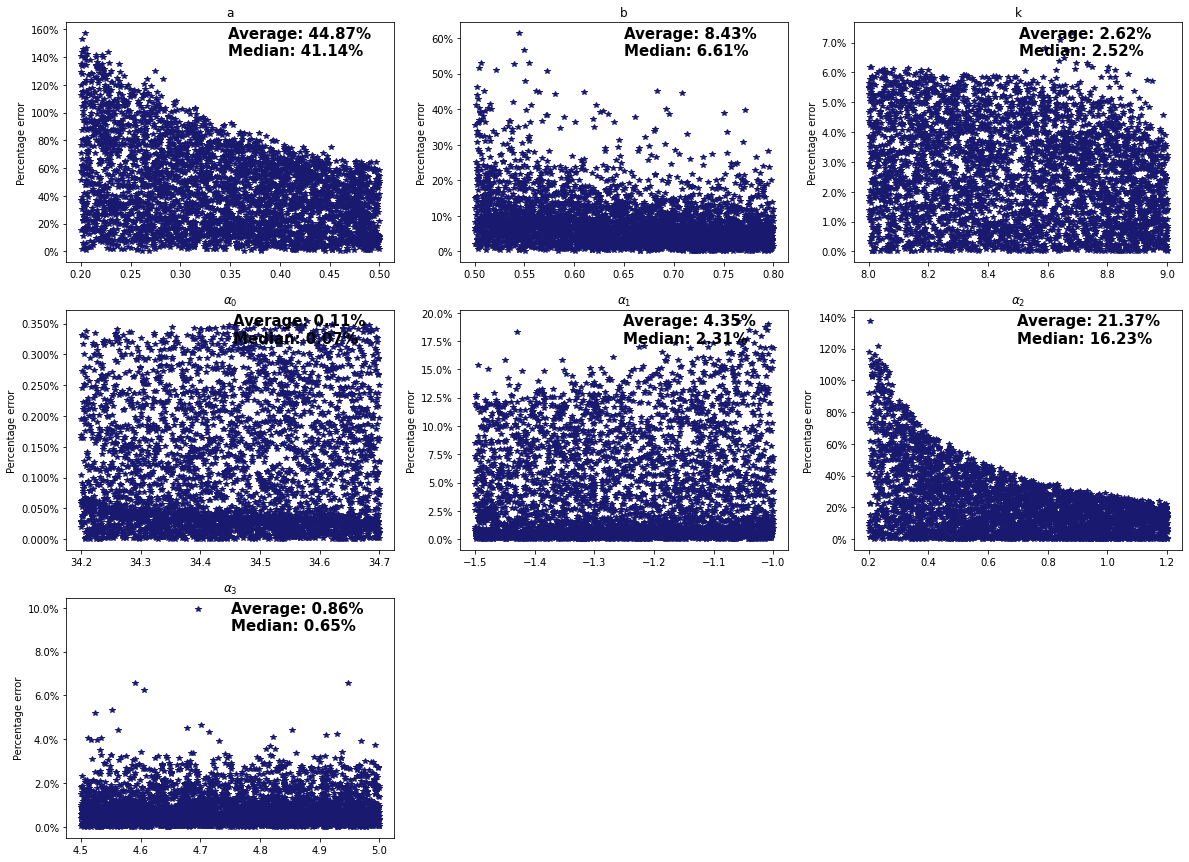

In [12]:
f = plt.figure(figsize = (20,15))
plt.subplot(3,3,1)
plt.plot(params_cal[:,0], percentage_err[:,0]*100,  '*', color = 'midnightblue')
plt.title('a')
plt.ylabel('Percentage error');
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter() )
s0 = 'Average: %.2f' %mean_percentage_err[0] + r'%' + '\n' + 'Median: %.2f' %median_percentage_err[0] + r'%'
plt.text(np.mean(params_cal[:,0]), np.max(percentage_err[:,0]*90), s0, fontsize=15, weight = 'bold')

plt.subplot(3,3,2)
plt.plot(params_cal[:,1], percentage_err[:,1]*100,  '*', color = 'midnightblue')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter() )
plt.title('b')
plt.ylabel('Percentage error');
s1 = 'Average: %.2f' %mean_percentage_err[1] + r'%' + '\n' + 'Median: %.2f' %median_percentage_err[1] + r'%'
plt.text(np.mean(params_cal[:,1]), np.max(percentage_err[:,1]*90), s1, fontsize=15, weight = 'bold')

plt.subplot(3,3,3)
plt.plot(params_cal[:,2], percentage_err[:,2]*100,  '*', color = 'midnightblue')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter() )
plt.title('k')
plt.ylabel('Percentage error');
s2 = 'Average: %.2f' %mean_percentage_err[2] + r'%' + '\n' + 'Median: %.2f' %median_percentage_err[2] + r'%'
plt.text(np.mean(params_cal[:,2]), np.max(percentage_err[:,2]*90), s2, fontsize=15, weight = 'bold')

plt.subplot(3,3,4)
plt.plot(params_cal[:,3], percentage_err[:,3]*100,  '*', color = 'midnightblue')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter() )
plt.title('$\\alpha_0$')
plt.ylabel('Percentage error');
s2 = 'Average: %.2f' %mean_percentage_err[3] + r'%' + '\n' + 'Median: %.2f' %median_percentage_err[3] + r'%'
plt.text(np.mean(params_cal[:,3]), np.max(percentage_err[:,3]*90), s2, fontsize=15, weight = 'bold')

plt.subplot(3,3,5)
plt.plot(params_cal[:,4], percentage_err[:,4]*100,  '*', color = 'midnightblue')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter() )
plt.title('$\\alpha_1$')
plt.ylabel('Percentage error');
s2 = 'Average: %.2f' %mean_percentage_err[4] + r'%' + '\n' + 'Median: %.2f' %median_percentage_err[4] + r'%'
plt.text(np.mean(params_cal[:,4]), np.max(percentage_err[:,4]*90), s2, fontsize=15, weight = 'bold')

plt.subplot(3,3,6)
plt.plot(params_cal[:,5], percentage_err[:,5]*100,  '*', color = 'midnightblue')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter() )
plt.title('$\\alpha_2$')
plt.ylabel('Percentage error');
s2 = 'Average: %.2f' %mean_percentage_err[5] + r'%' + '\n' + 'Median: %.2f' %median_percentage_err[5] + r'%'
plt.text(np.mean(params_cal[:,5]), np.max(percentage_err[:,5]*90), s2, fontsize=15, weight = 'bold')

plt.subplot(3,3,7)
plt.plot(params_cal[:,6], percentage_err[:,6]*100,  '*', color = 'midnightblue')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter() )
plt.title('$\\alpha_3$')
plt.ylabel('Percentage error');
s2 = 'Average: %.2f' %mean_percentage_err[6] + r'%' + '\n' + 'Median: %.2f' %median_percentage_err[6] + r'%'
plt.text(np.mean(params_cal[:,6]), np.max(percentage_err[:,6]*90), s2, fontsize=15, weight = 'bold');

#f.savefig('cal_gridbased_conv_with_NS.pdf', bbox_inches = 'tight', pad_inches = 0.01)

In [13]:
price_predicted_cal = model(new_input_guess).numpy()
price_predicted_cal = np.squeeze(price_predicted_cal)
err_training_cal = abs(price_predicted_cal-price_cal)/price_cal

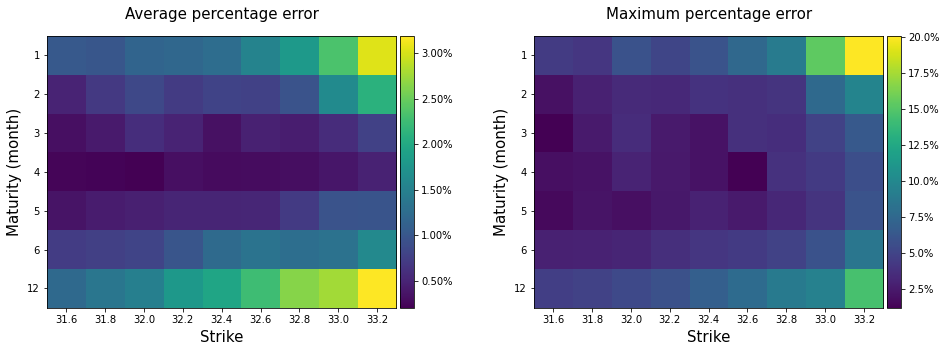

In [14]:
K_label = np.array([31.6, 31.8, 32.0, 32.2, 32.4, 32.6, 32.8, 33.0, 33.2])
tau_label = ['1', '2', '3', '4', '5', '6', '12']

f = plt.figure(1,figsize=(16,5))
ax = plt.subplot(1,2,1)
mean_err = np.mean(100*err_training_cal,axis = 0)
plt.title("Average percentage error", fontsize = 15, y = 1.04)
plt.imshow(np.transpose(mean_err))
plt.colorbar(format = mtick.PercentFormatter(), pad=0.01, fraction=0.046)
ax.set_xticks(np.linspace(0,N1-1,N1))
ax.set_xticklabels(K_label)
ax.set_yticks(np.linspace(0,N2-1,N2))
ax.set_yticklabels(tau_label)
plt.xlabel("Strike",fontsize=15,labelpad=5);
plt.ylabel("Maturity (month)",fontsize=15,labelpad=5);

ax = plt.subplot(1,2,2)
max_err = np.max(100*err_training_cal,axis = 0)
plt.title("Maximum percentage error", fontsize = 15, y = 1.04)
plt.imshow(np.transpose(max_err))
plt.colorbar(format = mtick.PercentFormatter(), pad=0.01, fraction=0.046)
ax.set_xticks(np.linspace(0,N1-1,N1))
ax.set_xticklabels(K_label)
ax.set_yticks(np.linspace(0,N2-1,N2))
ax.set_yticklabels(tau_label)
plt.xlabel("Strike",fontsize=15,labelpad=5);
plt.ylabel("Maturity (month)",fontsize=15,labelpad=5);

#f.savefig('error_step2_gridbased_conv_with_NS.pdf', bbox_inches = 'tight', pad_inches = 0.01)